In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pc
import ecg_plot

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add, GRU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional

### Data Prep

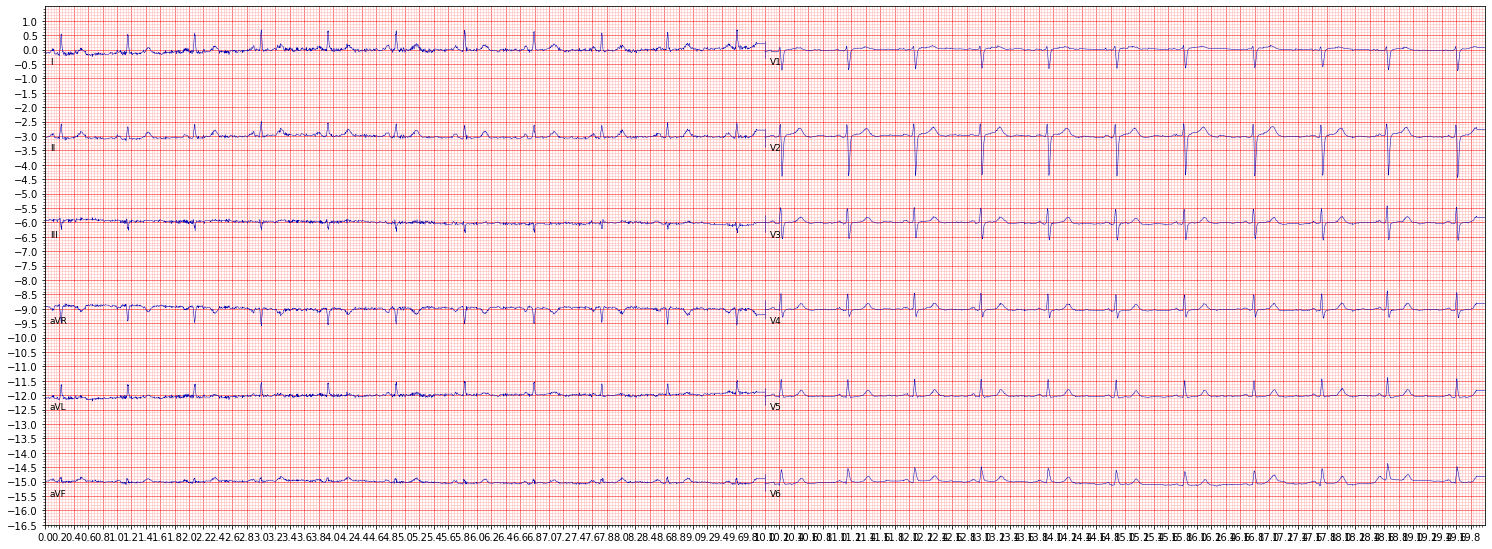

In [3]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
    
plot_ecg("WFDB/HR00001.mat")

In [4]:
gender, age, labels, ecg_filenames = pc.import_key_data("WFDB/")

In [5]:
ecg_filenames = np.asarray(ecg_filenames)

In [6]:
SNOMED_scored = pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [7]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '251146004' '270492004' '284470004' '39732003'
 '426177001' '426783006' '427084000' '427393009' '445118002' '47665007'
 '59931005' '63593006' '698252002' '713426002' '713427006'
 'undefined class']
classes: 23


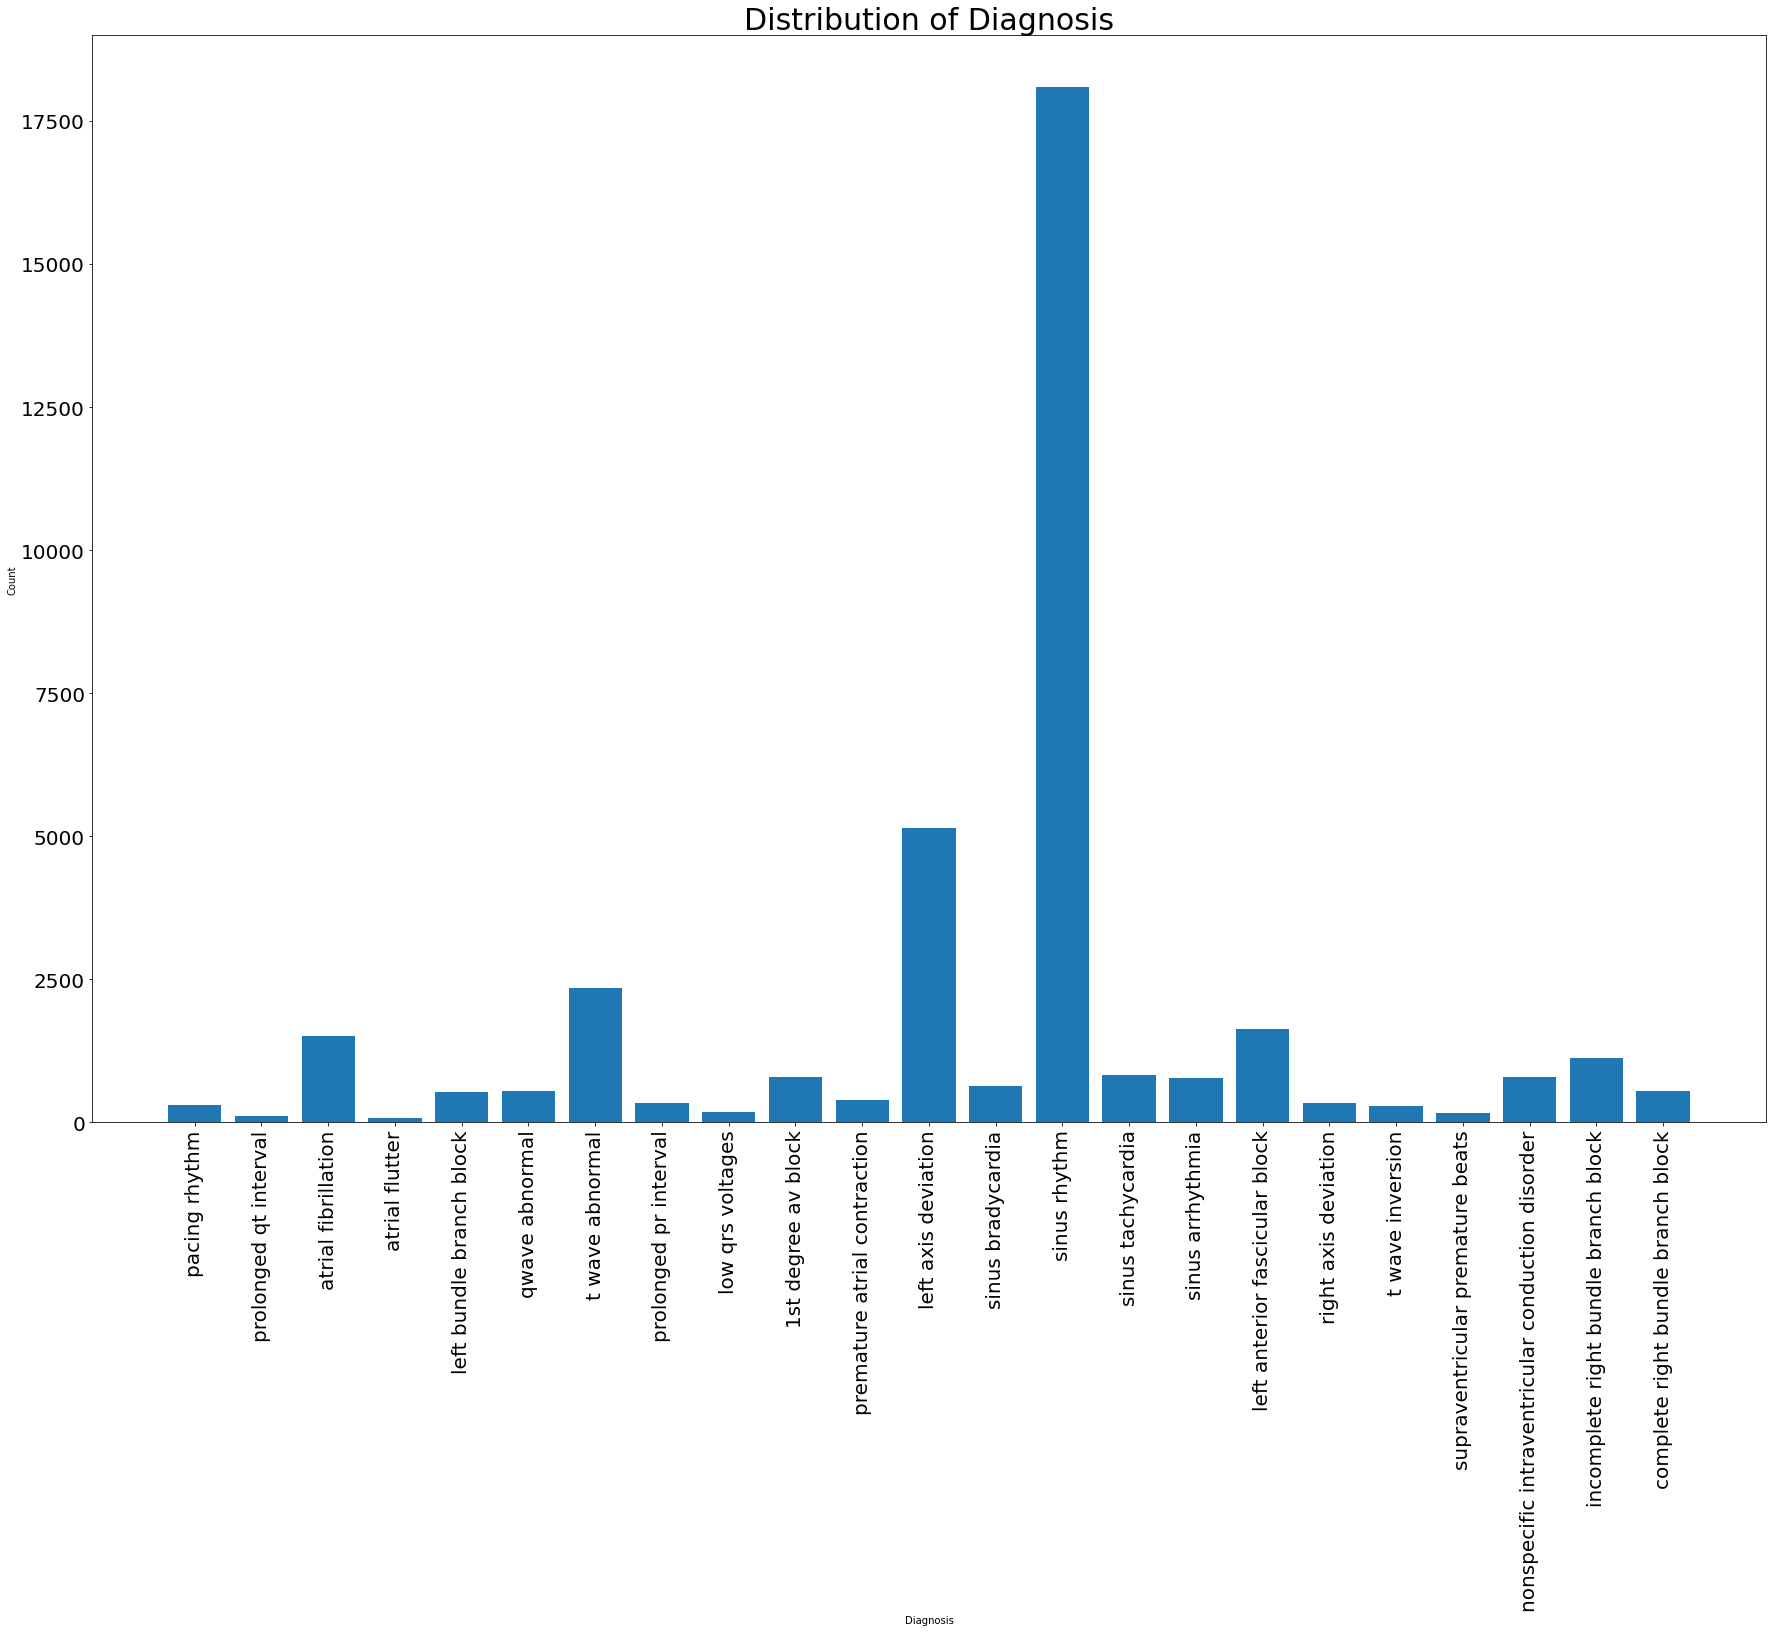

In [8]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [9]:
y_all_comb = pc.get_labels_for_all_combinations(y)
folds = pc.split_data(labels, y_all_comb)
order_array = folds[0][0]

Training split: 19653
Validation split: 2184


### Utility Functions

In [10]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) 
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=3, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=3)

In [12]:
batchsize = 8

### Inception Model

In [13]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(23,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [14]:
inception_model = inception_model(input_shape = (5000,12))
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [15]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 5006, 12)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5006, 64)     5440        zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5006, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________

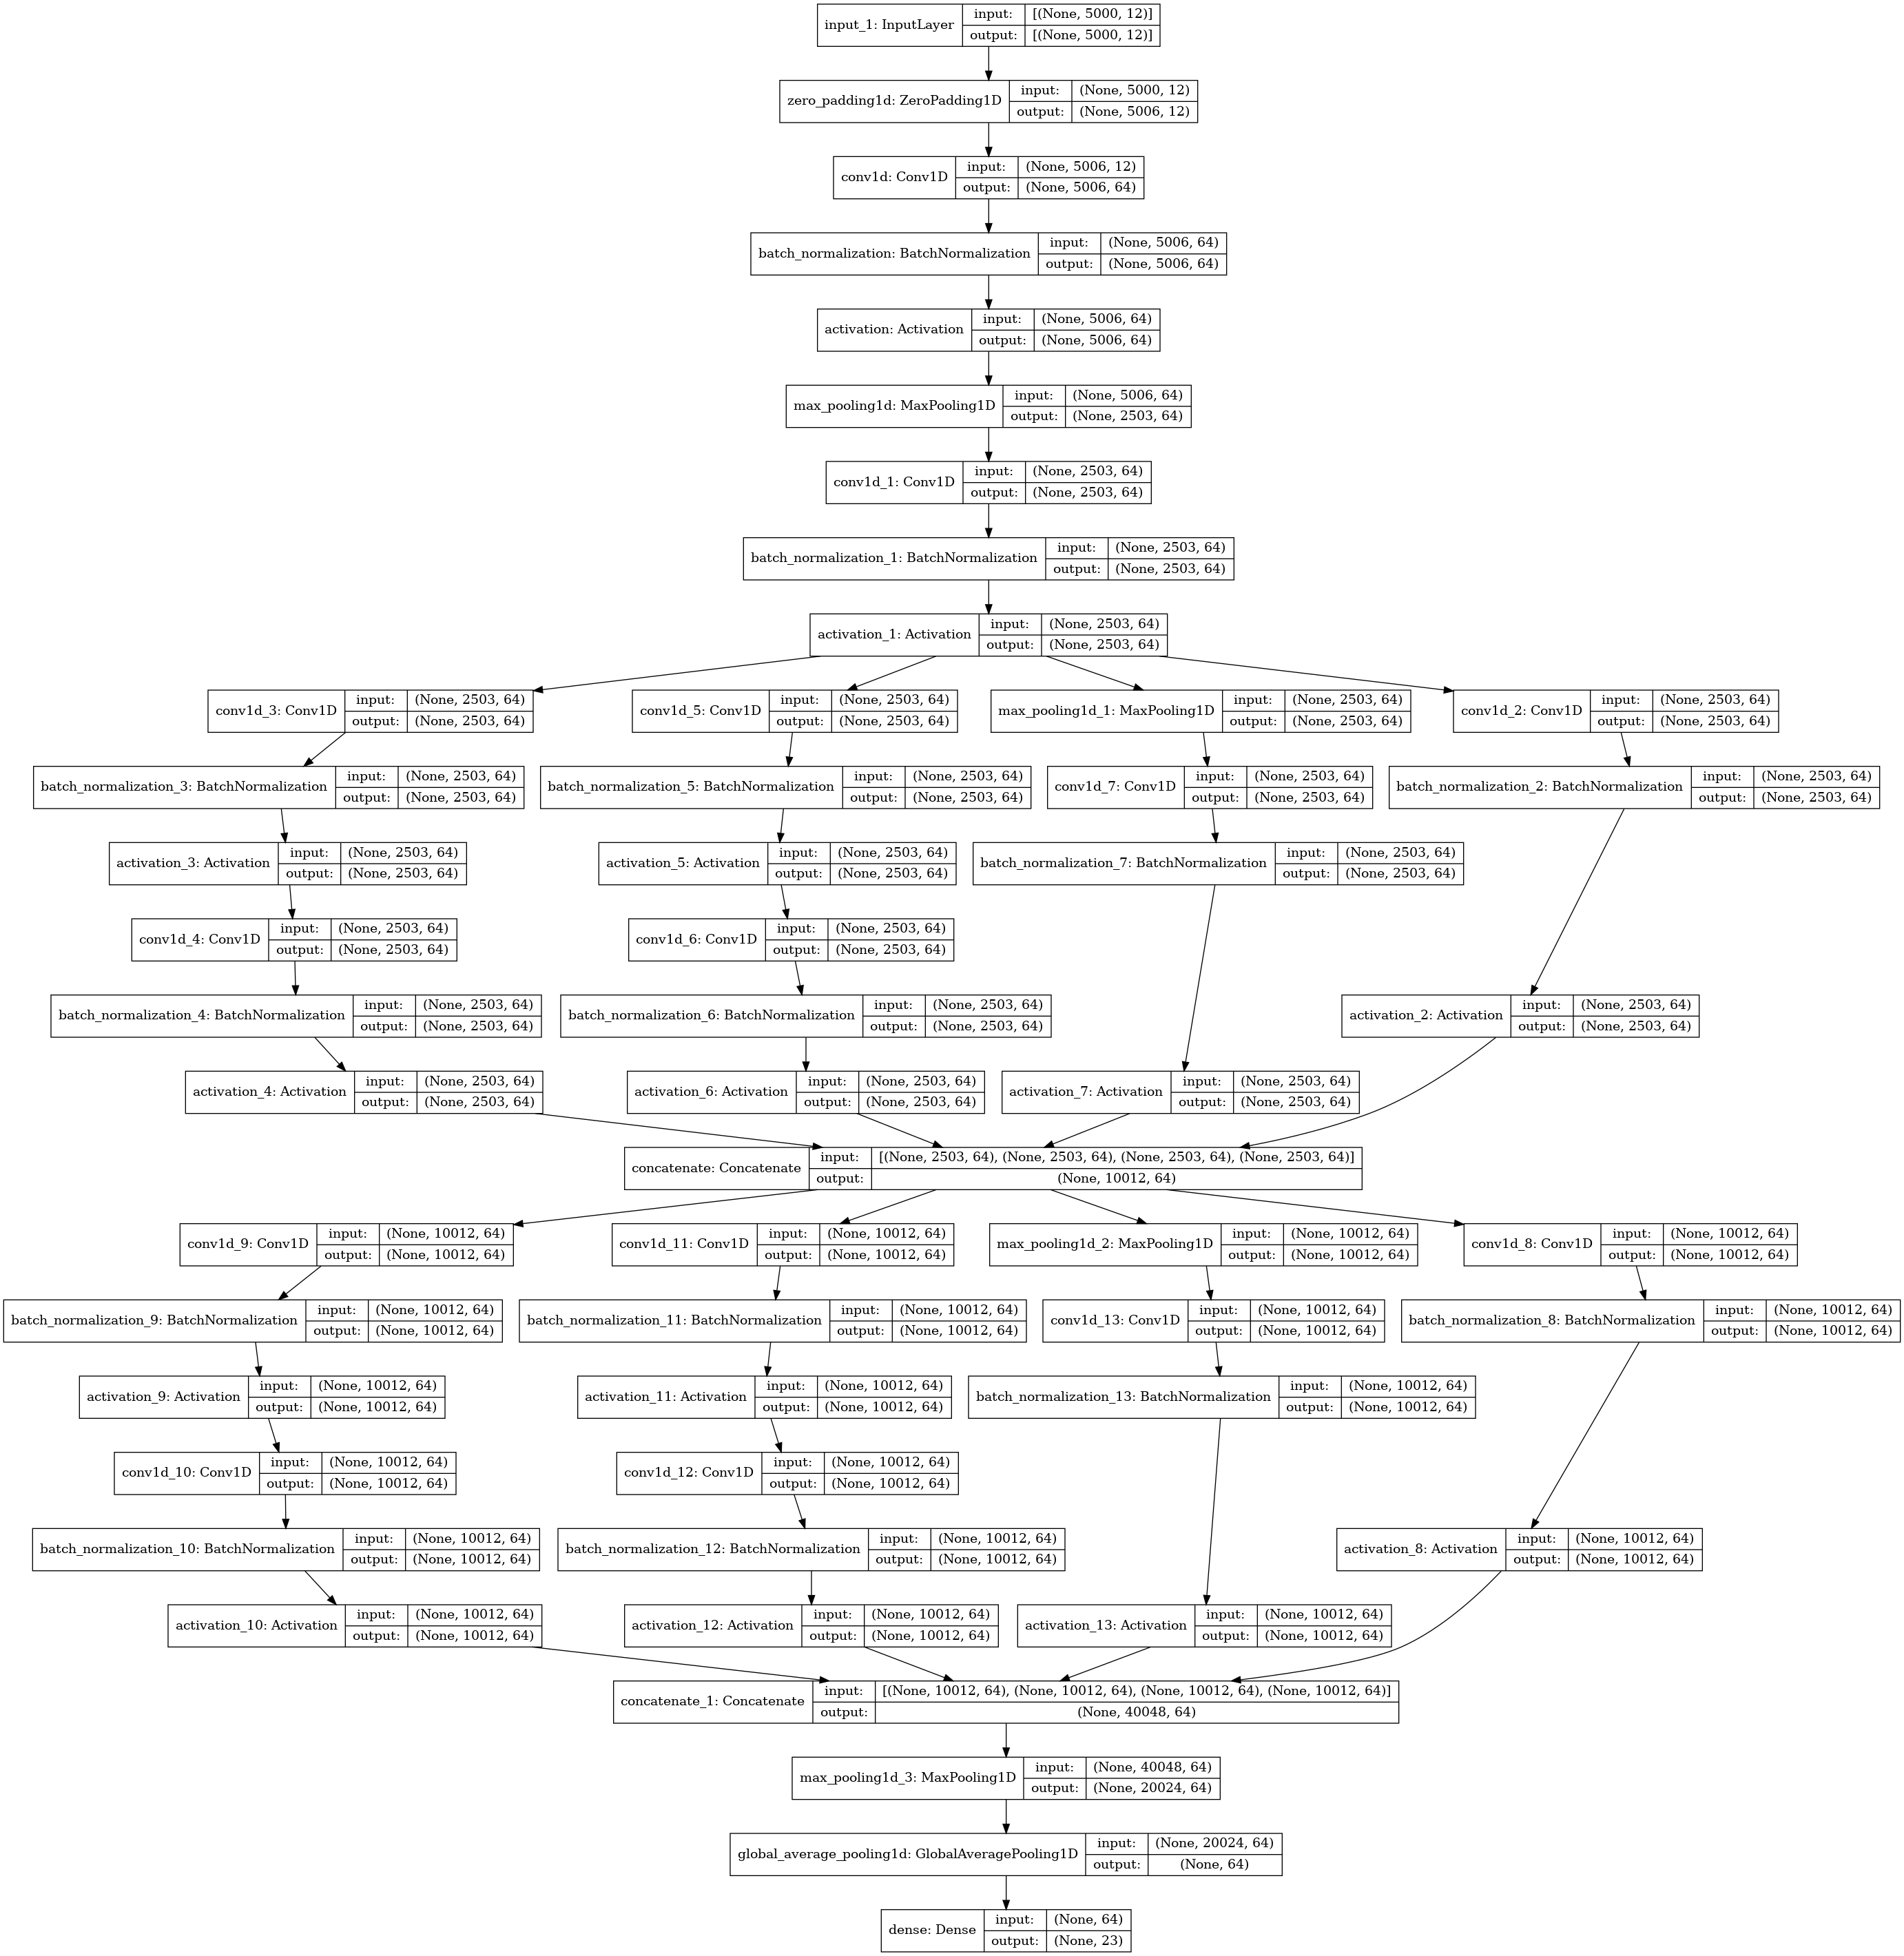

In [16]:
plot_model(inception_model, show_shapes=True)

In [17]:
inception_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=25, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/25
196/196 [==============================] - 12s 45ms/step - loss: 0.3764 - accuracy: 0.8533 - Recall: 0.4989 - Precision: 0.3282 - AUC: 0.5084 - val_loss: 0.1653 - val_accuracy: 0.9542 - val_Recall: 0.4777 - val_Precision: 0.8412 - val_AUC: 0.7305
Epoch 2/25
196/196 [==============================] - 8s 41ms/step - loss: 0.1459 - accuracy: 0.9543 - Recall: 0.4778 - Precision: 0.8484 - AUC: 0.6992 - val_loss: 0.1452 - val_accuracy: 0.9560 - val_Recall: 0.5330 - val_Precision: 0.8150 - val_AUC: 0.7648
Epoch 3/25
196/196 [==============================] - 8s 41ms/step - loss: 0.1346 - accuracy: 0.9576 - Recall: 0.5103 - Precision: 0.8528 - AUC: 0.7068 - val_loss: 0.1364 - val_accuracy: 0.9557 - val_Recall: 0.5021 - val_Precision: 0.8417 - val_AUC: 0.7762

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/25
196/196 [==============================] - 8s 41ms/step - loss: 0.1283 - accuracy: 0.9581 - Recall: 0.5223 - Precision: 0.8446 - AUC: 0

Text(0, 0.5, 'Accuracy')

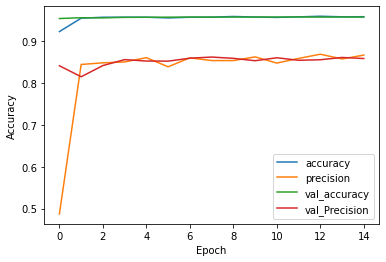

In [18]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

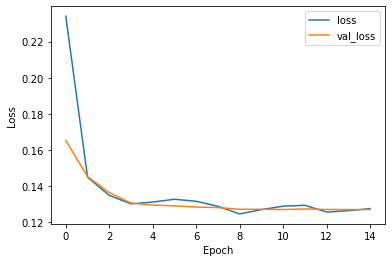

In [19]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

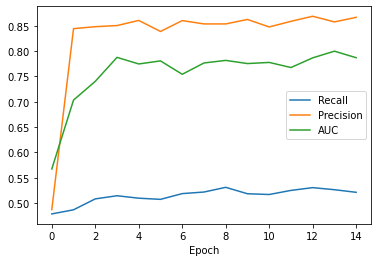

In [20]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [21]:
inception_model.save('inception_model.h5')

### Conv1D-Stack

In [22]:
model_conv1d = Sequential()

model_conv1d.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(Conv1D(filters=16, strides=1, kernel_size=5))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(GlobalAveragePooling1D())

model_conv1d.add(Dense(64, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(32, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(23, activation='sigmoid'))

In [23]:
model_conv1d.compile(loss = tf.keras.losses.BinaryCrossentropy(), \
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
                     metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5), tf.keras.metrics.Recall(name='Recall'), \
                              tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [24]:
model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 5000, 6)           222       
_________________________________________________________________
batch_normalization_14 (Batc (None, 5000, 6)           24        
_________________________________________________________________
activation_14 (Activation)   (None, 5000, 6)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2500, 6)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2496, 16)          496       
_________________________________________________________________
batch_normalization_15 (Batc (None, 2496, 16)          64        
_________________________________________________________________
activation_15 (Activation)   (None, 2496, 16)          0

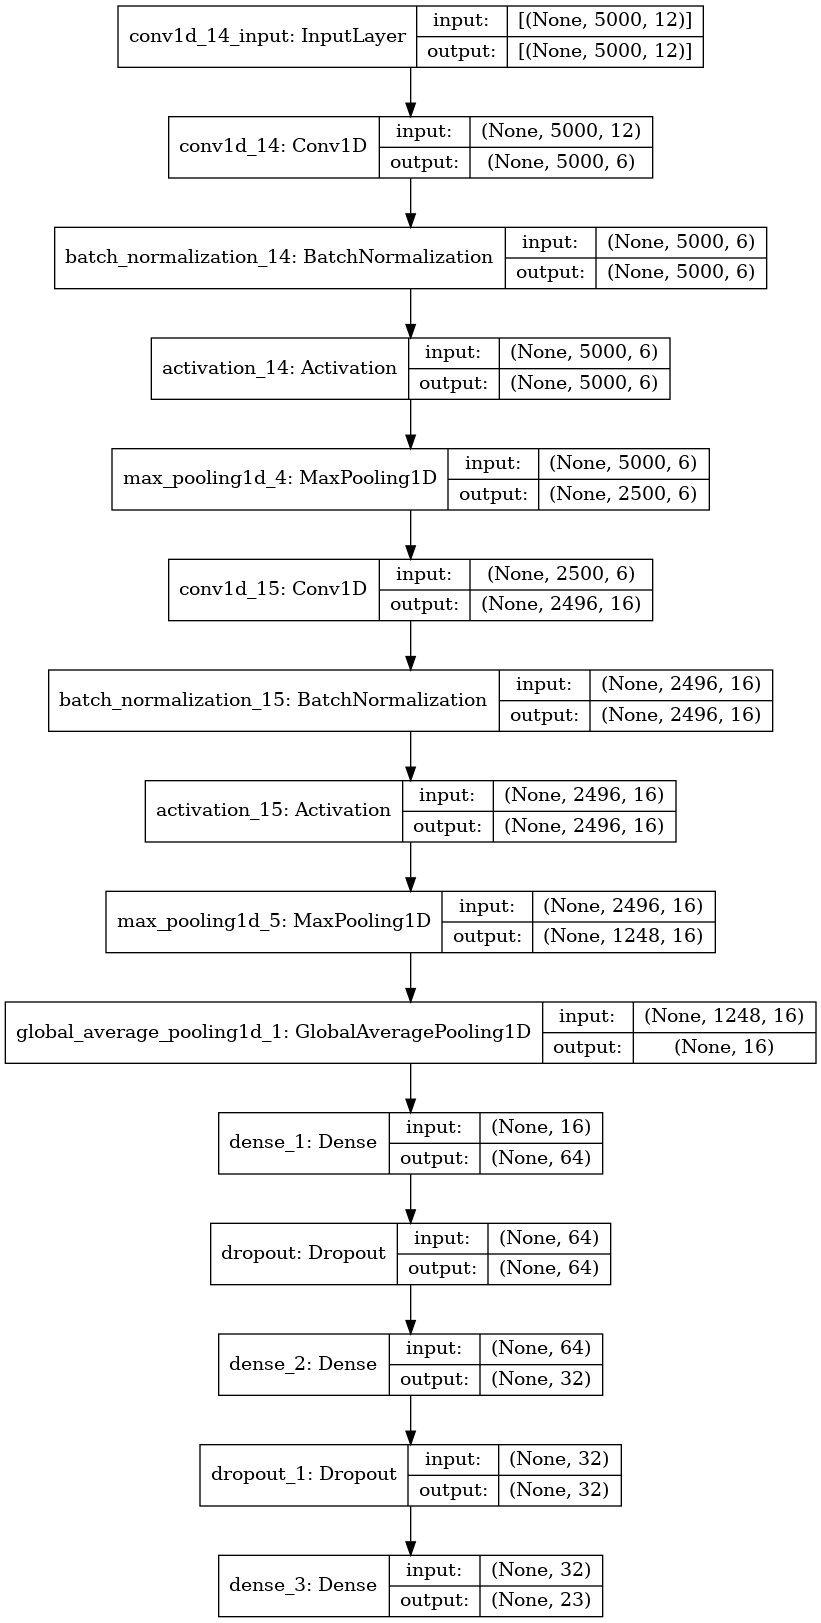

In [25]:
plot_model(model_conv1d, show_shapes=True)

In [26]:
model_conv1d.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=25, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/25
196/196 [==============================] - 3s 11ms/step - loss: 0.4454 - accuracy: 0.7962 - Recall: 0.2917 - Precision: 0.1763 - AUC: 0.5016 - val_loss: 0.2127 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6318
Epoch 2/25
196/196 [==============================] - 2s 8ms/step - loss: 0.1774 - accuracy: 0.9527 - Recall: 0.4756 - Precision: 0.8178 - AUC: 0.5171 - val_loss: 0.1600 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6373

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/25
196/196 [==============================] - 2s 8ms/step - loss: 0.1700 - accuracy: 0.9540 - Recall: 0.4875 - Precision: 0.8225 - AUC: 0.5374 - val_loss: 0.1585 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6297

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/25
196/196 [==============================] - 2s 8ms/step -

Text(0, 0.5, 'Accuracy')

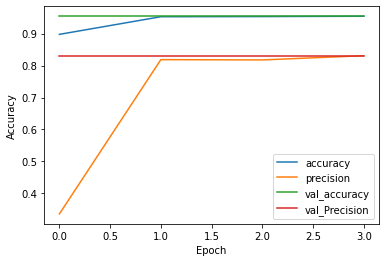

In [27]:
plt.plot(model_conv1d.history.history['accuracy'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['val_accuracy'])
plt.plot(model_conv1d.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

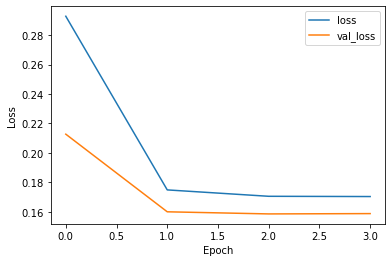

In [28]:
plt.plot(model_conv1d.history.history['loss'])
plt.plot(model_conv1d.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

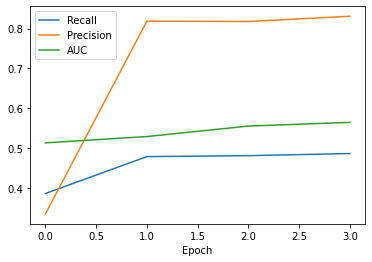

In [29]:
plt.plot(model_conv1d.history.history['Recall'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [30]:
model_conv1d.save('conv1dstack.h5')

### GRU Model

In [31]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.InputLayer((5000,12)))
lstm_model.add(GRU(64, return_sequences=True))
lstm_model.add(GRU(32, return_sequences = True))
lstm_model.add(GlobalAveragePooling1D())
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(23, activation = 'sigmoid'))

In [32]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [33]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5000, 128)         39424     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5000, 64)          41216     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 23)                2967      
Total params: 91,927
Trainable params: 91,927
Non-trainable params: 0
__________________________________________________

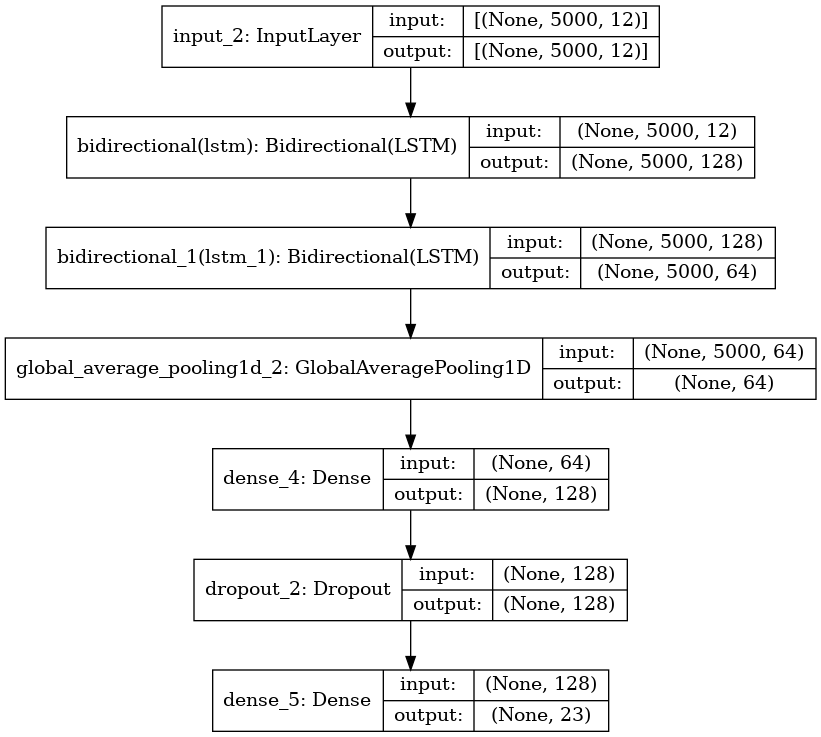

In [34]:
plot_model(lstm_model, show_shapes = True)

In [ ]:
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=25, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/25
196/196 [==============================] - 93s 456ms/step - loss: 0.2924 - accuracy: 0.9057 - Recall: 0.5378 - Precision: 0.4824 - AUC: 0.4895 - val_loss: 0.1615 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.5861
Epoch 2/25
196/196 [==============================] - 89s 456ms/step - loss: 0.1682 - accuracy: 0.9533 - Recall: 0.4833 - Precision: 0.8195 - AUC: 0.4894 - val_loss: 0.1589 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6449
Epoch 3/25
196/196 [==============================] - 88s 448ms/step - loss: 0.1579 - accuracy: 0.9559 - Recall: 0.4976 - Precision: 0.8380 - AUC: 0.5671 - val_loss: 0.1576 - val_accuracy: 0.9541 - val_Recall: 0.5221 - val_Precision: 0.7944 - val_AUC: 0.6600
Epoch 4/25
196/196 [==============================] - 90s 456ms/step - loss: 0.1473 - accuracy: 0.9586 - Recall: 0.5280 - Precision: 0.8445 - AUC: 0.5792 - val_loss: 0.1538 - val_accuracy: 0.9542 - val_Recall: 0.4838 - val_

In [ ]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
lstm_model.save('lstmmodel.h5')